## Comprehensive Explanation of the Python TrialSequence Class
Below is a high-level overview of a Python codebase that translates the core logic of the R `trial_sequence` class (commonly used in target trial emulation packages) into Python. The goal is to provide a structure where data, weights, and outcome models can be managed in a similar way to R.

### Purpose and Context
In R, the `trial_sequence` class (from libraries like TrialEmulation) manages data, weights, and outcome models in a target trial framework. This Python translation follows the same conceptual steps:

1. **Data Management**: Setting raw data, mapping columns, and expanding the data over multiple time periods.
2. **Weighting**: Setting and calculating weights for switching (treatment changes) and censoring.
3. **Outcome Modeling**: Defining an outcome model and fitting a marginal structural model (MSM).
4. **Subsetting and Loading**: Optionally filtering or sampling data from the expanded trial.

Since Python does not have built-in S4 classes, the code uses a single Python class, TrialSequence, with various methods that correspond to the R generics.

### Dummy Functions
Two helper functions illustrate how you might integrate external logic:

- `stats_glm_logit(save_path=None)`: Acts as a placeholder for a logistic regression model fitter. In a real application, you would replace this with actual model-fitting routines, such as from statsmodels or scikit-learn.

- `save_to_csv(output_dir)`: Represents a placeholder for saving data to CSV. In practice, you could implement real file-writing or database export logic.

### The TrialSequence Class
##### Core Attributes
- `estimand`: A string specifying the type of analysis (for example, “ITT” or “PP”).
- `data`: The main DataFrame containing person-time records.
- `outcome_data`: A separate DataFrame that can store data after expansion or subsetting.
- `data_mapping`: A dictionary mapping internal fields like "id", "period", "treatment" to column names in data.
- `expansion`: A dictionary containing parameters for data expansion, such as chunk size and the first/last period.
- `outcome_model`: A dictionary describing how to fit the outcome model, including formulas and a model fitter.
- `switch_weights and censor_weights`: Dictionaries holding formulas and model-fitting instructions for switching and censoring weight models, respectively.

### Methods Overview
1. `set_data(...)`
    - Assigns a DataFrame to self.data and updates data_mapping. This mimics the R method set_data(trial_sequence, data, ...).

2. `set_switch_weight_model(...) / set_censor_weight_model(...)`
    - Saves the relevant formulas and a model fitter for calculating switching or censoring weights. These correspond to S4 methods in R such as set_switch_weight_model(trial_sequence, ...).

3. `calculate_weights(...)`
    - Simulates the calculation of IP weights. In real usage, you would implement logic for inverse probability weighting. Here, it simply sets columns like "switch_weight" or "censor_weight" to a constant value, then creates a combined "weight" column if it does not already exist.

4. `show_weight_models(...)`
    - Prints summaries of the switching and censoring weight models, mirroring the R function show_weight_models(trial_sequence).

5. `set_outcome_model(...)`
    - Defines outcome model parameters, such as the treatment variable, adjustment terms, follow-up time terms, and a model fitter. This parallels set_outcome_model(trial_sequence, ...) in R.

6. `set_expansion_options(...)`
    - Stores details about how to expand the data. In R, you would call set_expansion_options(trial_sequence, output, chunk_size, ...).

7. `expand_trials(...)`
    - Filters data according to first_period and last_period, then divides the data into chunks (printing messages as if saving them). In a real scenario, the data might be written to disk. This corresponds to expand_trials(trial_sequence) in R.

8. `_fit_outcome_model(...)`
    - An internal method called by fit_msm. Returns a summary string that references the model fitter and mean weight. Real implementations would use actual regression or survival modeling.

9. `fit_msm(...)`
    - Combines weights (by multiplying columns like "weight" and "sample_weight") and optionally applies a user-supplied function (modify_weights) for truncation or smoothing. Then calls _fit_outcome_model to produce a dummy fitted result. This mimics fit_msm(trial_sequence, ...) in R.

10. `load_expanded_data(...)`
    - Subsets or samples the expanded data and stores it in outcome_data. This can involve filtering by period, applying a query string, or sampling controls with p_control. In R, you might see load_expanded_data(trial_sequence, ...).


### Key Takeaways
1. **Structural Translation**: This Python class is structurally similar to the R trial_sequence S4 class, allowing you to define data, set models, compute weights, and fit MSMs.
2. **Dummy Logic**: The actual statistical methods (logistic regression, IP weighting) are replaced with placeholders. You can integrate statsmodels or other Python libraries to replicate the R methods fully.
3. **Workflow Parity**: The methods (set_data, set_switch_weight_model, calculate_weights, expand_trials, fit_msm, etc.) mimic the R function names and usage patterns.
4. **Extendability**: You can adapt or extend this code to handle real-world data, advanced weighting schemes, or more sophisticated modeling—just replace the placeholders with your actual logic.

In [235]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

def stats_glm_logit(save_path=None):
    """
    Dummy model fitter function to mimic a te_model_fitter object.
    Replace this with your actual logistic regression model fitter.
    """
    return f"GLM_Logit_Model_Fitter(save_path={save_path})"

def save_to_csv(output_dir):
    """
    Dummy function to mimic a te_datastore object as created by save_to_csv().
    In practice, this would configure a datastore for writing CSV files.
    """
    return f"te_datastore_csv({output_dir})"

class TrialSequence:
    """
    TrialSequence class

    Attributes:
        estimand (str): Descriptive name of the estimand.
        data (pd.DataFrame): Expanded trial data in long (person-time) format.
        outcome_data (pd.DataFrame): Outcome data loaded via load_expanded_data.
        data_mapping (dict): Mapping of variable names (e.g., "period", "treatment", etc.).
        expansion: Options for data expansion.
        outcome_model (dict): Outcome model specifications.
        censor_weight: Object for informative censoring weights.
        switch_weights (dict): Parameters for switching weight models.
        censor_weights (dict): Parameters for censoring weight models.
    """
    __slots__ = [
        'estimand', 'data', 'outcome_data', 'data_mapping', 'expansion',
        'outcome_model', 'censor_weight', 'switch_weights', 'censor_weights'
    ]

    def __init__(self, estimand, data=None, expansion=None, outcome_model=None,
                 outcome_data=None, censor_weight=None):
        self.estimand = estimand
        self.data = data
        self.expansion = expansion
        self.outcome_model = outcome_model
        self.outcome_data = outcome_data
        self.censor_weight = censor_weight
        self.data_mapping = {}
        self.switch_weights = {}
        self.censor_weights = {}

    def set_data(self, data, id="id", period="period", treatment="treatment",
                 outcome="outcome", eligible="eligible"):
        self.data = data
        self.data_mapping = {
            "id": id,
            "period": period,
            "treatment": treatment,
            "outcome": outcome,
            "eligible": eligible,
        }
        return self

    def set_switch_weight_model(self, numerator, denominator, model_fitter,
                                eligible_wts_0=None, eligible_wts_1=None):
        self.switch_weights = {
            "numerator": numerator,
            "denominator": denominator,
            "model_fitter": model_fitter,
            "eligible_wts_0": eligible_wts_0,
            "eligible_wts_1": eligible_wts_1,
        }
        return self

    def set_censor_weight_model(self, censor_event, numerator, denominator,
                                pool_models=None, model_fitter=None):
        if pool_models is None:
            pool_models = "numerator" if self.estimand == "ITT" else "none"
        self.censor_weights = {
            "censor_event": censor_event,
            "numerator": numerator,
            "denominator": denominator,
            "pool_models": pool_models,
            "model_fitter": model_fitter,
        }
        return self

    def calculate_weights(self, quiet=False, **kwargs):
        """
        Calculate weights based on the specified switching and censor models.
        This dummy implementation assigns constant weights and then creates a "weight" column.
        """
        if self.data is None:
            raise ValueError("No data has been set. Please use set_data() to provide data.")

        # Simulate switching weight calculation.
        if self.switch_weights and self.switch_weights.get("model_fitter"):
            self.data["switch_weight"] = 1.0  # Dummy calculation
            self.switch_weights["calculated"] = True
            if not quiet:
                print("Switch weight model summary:")
                print("  Numerator formula:", self.switch_weights.get("numerator"))
                print("  Denominator formula:", self.switch_weights.get("denominator"))
                print("  Model fitter:", self.switch_weights.get("model_fitter"))

        # Simulate censor weight calculation.
        if self.censor_weights and self.censor_weights.get("model_fitter"):
            self.data["censor_weight"] = 1.0  # Dummy calculation
            self.censor_weights["calculated"] = True
            if not quiet:
                print("Censor weight model summary:")
                print("  Censor event column:", self.censor_weights.get("censor_event"))
                print("  Numerator formula:", self.censor_weights.get("numerator"))
                print("  Denominator formula:", self.censor_weights.get("denominator"))
                print("  Pool models option:", self.censor_weights.get("pool_models"))
                print("  Model fitter:", self.censor_weights.get("model_fitter"))

        # --- FIX: Create a "weight" column ---
        if "weight" not in self.data.columns:
            if "switch_weight" in self.data.columns and "censor_weight" in self.data.columns:
                self.data["weight"] = self.data["switch_weight"] * self.data["censor_weight"]
            elif "switch_weight" in self.data.columns:
                self.data["weight"] = self.data["switch_weight"]
            elif "censor_weight" in self.data.columns:
                self.data["weight"] = self.data["censor_weight"]
            else:
                self.data["weight"] = 1.0
            if not quiet:
                print("Created 'weight' column from available weight components.")

        return self

    def show_weight_models(self):
        print("\nWeight Models Summary:")
        if self.switch_weights.get("calculated"):
            print("Switch Weight Model:")
            print("  Numerator formula:", self.switch_weights.get("numerator"))
            print("  Denominator formula:", self.switch_weights.get("denominator"))
            print("  Model fitter:", self.switch_weights.get("model_fitter"))
        else:
            print("Switch Weight Model: Not calculated or not set.")
        if self.censor_weights.get("calculated"):
            print("Censor Weight Model:")
            print("  Censor event column:", self.censor_weights.get("censor_event"))
            print("  Numerator formula:", self.censor_weights.get("numerator"))
            print("  Denominator formula:", self.censor_weights.get("denominator"))
            print("  Pool models option:", self.censor_weights.get("pool_models"))
            print("  Model fitter:", self.censor_weights.get("model_fitter"))
        else:
            print("Censor Weight Model: Not calculated or not set.")

    def set_outcome_model(self, treatment_var=None, adjustment_terms=None,
                          followup_time_terms=None, trial_period_terms=None,
                          model_fitter=None):
        if treatment_var is None:
            treatment_var = "assigned_treatment" if self.estimand in ["ITT", "PP"] else "~0"
        if adjustment_terms is None:
            adjustment_terms = "~1"
        if followup_time_terms is None:
            followup_time_terms = "~followup_time + I(followup_time^2)"
        if trial_period_terms is None:
            trial_period_terms = "~trial_period + I(trial_period^2)"
        self.outcome_model = {
            "treatment_var": treatment_var,
            "adjustment_terms": adjustment_terms,
            "followup_time_terms": followup_time_terms,
            "trial_period_terms": trial_period_terms,
            "model_fitter": model_fitter,
        }
        return self

    def set_expansion_options(self, output, chunk_size, first_period=0, last_period=math.inf):
        self.expansion = {
            "output": output,
            "chunk_size": chunk_size,
            "first_period": first_period,
            "last_period": last_period
        }
        return self

    def expand_trials(self):
        """
        Expand the trial data according to the expansion options.
        This dummy implementation filters data based on period limits, splits into chunks,
        and then reassembles the chunks.
        """
        if self.expansion is None:
            print("No expansion options set. Returning original trial sequence.")
            return self
        if self.data is None:
            raise ValueError("No data has been set. Please use set_data() to provide data.")

        output = self.expansion.get("output")
        chunk_size = self.expansion.get("chunk_size")
        first_period = self.expansion.get("first_period")
        last_period = self.expansion.get("last_period")
        period_col = self.data_mapping.get("period", "period")
        expanded_data = self.data.copy()
        if period_col in expanded_data.columns:
            if not math.isinf(last_period):
                expanded_data = expanded_data[(expanded_data[period_col] >= first_period) &
                                              (expanded_data[period_col] <= last_period)]
            else:
                expanded_data = expanded_data[expanded_data[period_col] >= first_period]
        else:
            print(f"Warning: Period column '{period_col}' not found in data.")

        num_records = len(expanded_data)
        num_chunks = math.ceil(num_records / chunk_size)
        print(f"Expanding trials: {num_records} records will be divided into {num_chunks} chunk(s).")
        chunks = []
        for i in range(num_chunks):
            start_idx = i * chunk_size
            end_idx = start_idx + chunk_size
            chunk = expanded_data.iloc[start_idx:end_idx]
            chunks.append(chunk)
            print(f"Saving chunk {i + 1}/{num_chunks} to datastore: {output}")

        self.data = pd.concat(chunks, ignore_index=True)
        print("Trial data expansion complete.")
        return self

    def _fit_outcome_model(self, outcome_dataset, weights):
        """
        Internal method to 'fit' the outcome marginal structural model.
        This dummy implementation returns a summary string.
        """
        model_fitter = self.outcome_model.get("model_fitter")
        mean_weight = weights.mean() if weights is not None else np.nan
        fitted_summary = (f"Fitted MSM using {model_fitter} with mean weight {mean_weight:.3f} "
                          f"and adjustment_terms {self.outcome_model.get('adjustment_terms')}")
        return fitted_summary

    def fit_msm(self, weight_cols=["weight", "sample_weight"], modify_weights=None):
        """
        Fit the outcome marginal structural model (MSM).
        Combines weights from specified columns (default: "weight" and "sample_weight").
        """
        outcome_dataset = self.outcome_data if self.outcome_data is not None else self.data
        if outcome_dataset is None:
            raise ValueError("No outcome data available. Please set data and expand trials before fitting MSM.")

        # Compute combined weights; if a column is missing, default to ones.
        weights = pd.Series(1, index=outcome_dataset.index, dtype=float)
        for col in weight_cols:
            if col not in outcome_dataset.columns:
                print(f"Warning: Weight column '{col}' not found. Using default value 1 for this column.")
                temp = pd.Series(1, index=outcome_dataset.index, dtype=float)
            else:
                temp = outcome_dataset[col]
            weights *= temp

        # Optionally modify the weights.
        if modify_weights is not None:
            weights = modify_weights(weights)

        fitted_summary = self._fit_outcome_model(outcome_dataset, weights)
        self.outcome_model["fitted_model"] = fitted_summary
        print("Outcome MSM fitting complete.")
        print("Fitted outcome model summary:")
        print(fitted_summary)
        return self

    def load_expanded_data(self, p_control=None, period=None, subset_condition=None, seed=None):
        """
        Load, subset, and optionally sample the expanded trial data.
        The resulting data is stored in outcome_data.
        """
        if self.data is None:
            raise ValueError("No expanded data available. Please call expand_trials() first.")
        outcome_df = self.data.copy()
        period_col = self.data_mapping.get("period", "period")
        if period is not None:
            outcome_df = outcome_df[outcome_df[period_col].isin(period)]
            print(f"Data filtered to trial periods: {period}")
        if subset_condition is not None:
            try:
                outcome_df = outcome_df.query(subset_condition)
                print(f"Data subset using condition: {subset_condition}")
            except Exception as e:
                raise ValueError(f"Error applying subset_condition: {e}")
        if seed is not None:
            np.random.seed(seed)
            print(f"Random seed set to: {seed}")
        if p_control is not None:
            treatment_col = self.data_mapping.get("treatment", "treatment")
            is_control = outcome_df[treatment_col] == 0
            controls = outcome_df[is_control]
            treated = outcome_df[~is_control]
            sampled_controls = controls.sample(frac=p_control, random_state=seed)
            outcome_df = pd.concat([treated, sampled_controls], ignore_index=True)
            print(f"Control sampling applied with probability: {p_control}")
        self.outcome_data = outcome_df
        print("Expanded outcome data loaded successfully.")
        return self

    def __repr__(self):
        return (f"TrialSequence(estimand={self.estimand!r}, data_mapping={self.data_mapping}, "
                f"outcome_model={self.outcome_model}, expansion={self.expansion})")

# --- Example modify_weights functions ---

def limit_weight(lower_limit, upper_limit):
    def limiter(w):
        return w.clip(lower=lower_limit, upper=upper_limit)
    return limiter

def p99_weight(w):
    lower = w.quantile(0.01)
    upper = w.quantile(0.99)
    return w.clip(lower=lower, upper=upper)

def all_ones(w):
    return pd.Series(1, index=w.index)


In [236]:
trial_pp = TrialSequence("PP")
trial_itt = TrialSequence("ITT")

In [237]:
data_censored = pd.read_csv("../data/data_censored.csv")

data_censored.head()

,id,period,treatment,x1,x2,x3,x4,age,age_s,outcome,censored,eligible
0,1,0,1,1,1.146148,0,0.734203,36,0.083333,0,0,1
1,1,1,1,1,0.002200,0,0.734203,37,0.166667,0,0,0
2,1,2,1,0,-0.481762,0,0.734203,38,0.250000,0,0,0
3,1,3,1,0,0.007872,0,0.734203,39,0.333333,0,0,0
4,1,4,1,1,0.216054,0,0.734203,40,0.416667,0,0,0


In [238]:
trial_pp.set_data(data_censored, id="id", period="period", treatment="treatment",
                  outcome="outcome", eligible="eligible")

TrialSequence(estimand='PP', data_mapping={'id': 'id', 'period': 'period', 'treatment': 'treatment', 'outcome': 'outcome', 'eligible': 'eligible'}, outcome_model=None, expansion=None)

In [239]:
trial_pp

TrialSequence(estimand='PP', data_mapping={'id': 'id', 'period': 'period', 'treatment': 'treatment', 'outcome': 'outcome', 'eligible': 'eligible'}, outcome_model=None, expansion=None)

In [240]:
trial_itt.set_data(data_censored, id="id", period="period", treatment="treatment",
                  outcome="outcome", eligible="eligible")

TrialSequence(estimand='ITT', data_mapping={'id': 'id', 'period': 'period', 'treatment': 'treatment', 'outcome': 'outcome', 'eligible': 'eligible'}, outcome_model=None, expansion=None)

In [241]:
trial_itt

TrialSequence(estimand='ITT', data_mapping={'id': 'id', 'period': 'period', 'treatment': 'treatment', 'outcome': 'outcome', 'eligible': 'eligible'}, outcome_model=None, expansion=None)

In [242]:
trial_pp.set_switch_weight_model(numerator="~ age", denominator="~ age + x1 + x3", model_fitter = stats_glm_logit(save_path="switch_models"))

TrialSequence(estimand='PP', data_mapping={'id': 'id', 'period': 'period', 'treatment': 'treatment', 'outcome': 'outcome', 'eligible': 'eligible'}, outcome_model=None, expansion=None)

In [243]:
trial_pp.set_censor_weight_model(
    censor_event="censored",
    numerator="~ x2",
    denominator="~ x2 + x1",
    pool_models="none",
    model_fitter=stats_glm_logit(save_path="censor_models")
)

trial_pp.censor_weights

{'censor_event': 'censored',
 'numerator': '~ x2',
 'denominator': '~ x2 + x1',
 'pool_models': 'none',
 'model_fitter': 'GLM_Logit_Model_Fitter(save_path=censor_models)'}

In [244]:
trial_itt.set_censor_weight_model(
    censor_event="censored",
    numerator="~ x2",
    denominator="~ x2 + x1",
    pool_models="numerator",
    model_fitter=stats_glm_logit(save_path="censor_models")
)

trial_itt.censor_weights

{'censor_event': 'censored',
 'numerator': '~ x2',
 'denominator': '~ x2 + x1',
 'pool_models': 'numerator',
 'model_fitter': 'GLM_Logit_Model_Fitter(save_path=censor_models)'}

In [245]:
trial_pp.calculate_weights()
trial_itt.calculate_weights()

Switch weight model summary:
  Numerator formula: ~ age
  Denominator formula: ~ age + x1 + x3
  Model fitter: GLM_Logit_Model_Fitter(save_path=switch_models)
Censor weight model summary:
  Censor event column: censored
  Numerator formula: ~ x2
  Denominator formula: ~ x2 + x1
  Pool models option: none
  Model fitter: GLM_Logit_Model_Fitter(save_path=censor_models)
Created 'weight' column from available weight components.
Censor weight model summary:
  Censor event column: censored
  Numerator formula: ~ x2
  Denominator formula: ~ x2 + x1
  Pool models option: numerator
  Model fitter: GLM_Logit_Model_Fitter(save_path=censor_models)


TrialSequence(estimand='ITT', data_mapping={'id': 'id', 'period': 'period', 'treatment': 'treatment', 'outcome': 'outcome', 'eligible': 'eligible'}, outcome_model=None, expansion=None)

In [246]:
trial_itt.show_weight_models()


Weight Models Summary:
Switch Weight Model: Not calculated or not set.
Censor Weight Model:
  Censor event column: censored
  Numerator formula: ~ x2
  Denominator formula: ~ x2 + x1
  Pool models option: numerator
  Model fitter: GLM_Logit_Model_Fitter(save_path=censor_models)


In [247]:
trial_pp.show_weight_models()


Weight Models Summary:
Switch Weight Model:
  Numerator formula: ~ age
  Denominator formula: ~ age + x1 + x3
  Model fitter: GLM_Logit_Model_Fitter(save_path=switch_models)
Censor Weight Model:
  Censor event column: censored
  Numerator formula: ~ x2
  Denominator formula: ~ x2 + x1
  Pool models option: none
  Model fitter: GLM_Logit_Model_Fitter(save_path=censor_models)


In [248]:
trial_pp.set_outcome_model()

TrialSequence(estimand='PP', data_mapping={'id': 'id', 'period': 'period', 'treatment': 'treatment', 'outcome': 'outcome', 'eligible': 'eligible'}, outcome_model={'treatment_var': 'assigned_treatment', 'adjustment_terms': '~1', 'followup_time_terms': '~followup_time + I(followup_time^2)', 'trial_period_terms': '~trial_period + I(trial_period^2)', 'model_fitter': None}, expansion=None)

In [249]:
trial_itt.set_outcome_model()

TrialSequence(estimand='ITT', data_mapping={'id': 'id', 'period': 'period', 'treatment': 'treatment', 'outcome': 'outcome', 'eligible': 'eligible'}, outcome_model={'treatment_var': 'assigned_treatment', 'adjustment_terms': '~1', 'followup_time_terms': '~followup_time + I(followup_time^2)', 'trial_period_terms': '~trial_period + I(trial_period^2)', 'model_fitter': None}, expansion=None)

In [250]:
trial_pp.set_expansion_options(output=save_to_csv("output_dir"), chunk_size=500)

TrialSequence(estimand='PP', data_mapping={'id': 'id', 'period': 'period', 'treatment': 'treatment', 'outcome': 'outcome', 'eligible': 'eligible'}, outcome_model={'treatment_var': 'assigned_treatment', 'adjustment_terms': '~1', 'followup_time_terms': '~followup_time + I(followup_time^2)', 'trial_period_terms': '~trial_period + I(trial_period^2)', 'model_fitter': None}, expansion={'output': 'te_datastore_csv(output_dir)', 'chunk_size': 500, 'first_period': 0, 'last_period': inf})

In [251]:
trial_itt.set_expansion_options(output=save_to_csv("output_dir"), chunk_size=500)

TrialSequence(estimand='ITT', data_mapping={'id': 'id', 'period': 'period', 'treatment': 'treatment', 'outcome': 'outcome', 'eligible': 'eligible'}, outcome_model={'treatment_var': 'assigned_treatment', 'adjustment_terms': '~1', 'followup_time_terms': '~followup_time + I(followup_time^2)', 'trial_period_terms': '~trial_period + I(trial_period^2)', 'model_fitter': None}, expansion={'output': 'te_datastore_csv(output_dir)', 'chunk_size': 500, 'first_period': 0, 'last_period': inf})

In [252]:
trial_pp.expand_trials()

Expanding trials: 725 records will be divided into 2 chunk(s).
Saving chunk 1/2 to datastore: te_datastore_csv(output_dir)
Saving chunk 2/2 to datastore: te_datastore_csv(output_dir)
Trial data expansion complete.


TrialSequence(estimand='PP', data_mapping={'id': 'id', 'period': 'period', 'treatment': 'treatment', 'outcome': 'outcome', 'eligible': 'eligible'}, outcome_model={'treatment_var': 'assigned_treatment', 'adjustment_terms': '~1', 'followup_time_terms': '~followup_time + I(followup_time^2)', 'trial_period_terms': '~trial_period + I(trial_period^2)', 'model_fitter': None}, expansion={'output': 'te_datastore_csv(output_dir)', 'chunk_size': 500, 'first_period': 0, 'last_period': inf})

In [253]:
trial_itt.expand_trials()

Expanding trials: 725 records will be divided into 2 chunk(s).
Saving chunk 1/2 to datastore: te_datastore_csv(output_dir)
Saving chunk 2/2 to datastore: te_datastore_csv(output_dir)
Trial data expansion complete.


TrialSequence(estimand='ITT', data_mapping={'id': 'id', 'period': 'period', 'treatment': 'treatment', 'outcome': 'outcome', 'eligible': 'eligible'}, outcome_model={'treatment_var': 'assigned_treatment', 'adjustment_terms': '~1', 'followup_time_terms': '~followup_time + I(followup_time^2)', 'trial_period_terms': '~trial_period + I(trial_period^2)', 'model_fitter': None}, expansion={'output': 'te_datastore_csv(output_dir)', 'chunk_size': 500, 'first_period': 0, 'last_period': inf})

In [254]:
trial_pp.expansion

{'output': 'te_datastore_csv(output_dir)',
 'chunk_size': 500,
 'first_period': 0,
 'last_period': inf}

In [255]:
trial_itt.expansion

{'output': 'te_datastore_csv(output_dir)',
 'chunk_size': 500,
 'first_period': 0,
 'last_period': inf}

In [256]:
trial_itt.load_expanded_data(seed = 1234, p_control=0.5)

Random seed set to: 1234
Control sampling applied with probability: 0.5
Expanded outcome data loaded successfully.


TrialSequence(estimand='ITT', data_mapping={'id': 'id', 'period': 'period', 'treatment': 'treatment', 'outcome': 'outcome', 'eligible': 'eligible'}, outcome_model={'treatment_var': 'assigned_treatment', 'adjustment_terms': '~1', 'followup_time_terms': '~followup_time + I(followup_time^2)', 'trial_period_terms': '~trial_period + I(trial_period^2)', 'model_fitter': None}, expansion={'output': 'te_datastore_csv(output_dir)', 'chunk_size': 500, 'first_period': 0, 'last_period': inf})

In [257]:
trial_itt.fit_msm(weight_cols=["weight", "sample_weight"], modify_weights=p99_weight)

Outcome MSM fitting complete.
Fitted outcome model summary:
Fitted MSM using None with mean weight 1.000 and adjustment_terms ~1


TrialSequence(estimand='ITT', data_mapping={'id': 'id', 'period': 'period', 'treatment': 'treatment', 'outcome': 'outcome', 'eligible': 'eligible'}, outcome_model={'treatment_var': 'assigned_treatment', 'adjustment_terms': '~1', 'followup_time_terms': '~followup_time + I(followup_time^2)', 'trial_period_terms': '~trial_period + I(trial_period^2)', 'model_fitter': None, 'fitted_model': 'Fitted MSM using None with mean weight 1.000 and adjustment_terms ~1'}, expansion={'output': 'te_datastore_csv(output_dir)', 'chunk_size': 500, 'first_period': 0, 'last_period': inf})

In [258]:
trial_itt.outcome_model

{'treatment_var': 'assigned_treatment',
 'adjustment_terms': '~1',
 'followup_time_terms': '~followup_time + I(followup_time^2)',
 'trial_period_terms': '~trial_period + I(trial_period^2)',
 'model_fitter': None,
 'fitted_model': 'Fitted MSM using None with mean weight 1.000 and adjustment_terms ~1'}

In [259]:
trial_itt.outcome_model["fitted_model"]

'Fitted MSM using None with mean weight 1.000 and adjustment_terms ~1'

In [260]:
def predict(trial, newdata, predict_times, type="survival"):
    """
    Standalone prediction function for a TrialSequence object.

    Parameters:
        trial: A TrialSequence object (not used in dummy implementation, but could be used to access the fitted model).
        newdata: A pandas DataFrame containing the data for prediction.
        predict_times: An iterable of prediction times (e.g., range(0, 11)).
        type: A string indicating the prediction type (e.g., "survival").

    Returns:
        A dictionary with prediction results in the following structure:
        {
            "difference": {
                "followup_time": np.array([...]),
                "survival_diff": np.array([...]),
                "2.5%": np.array([...]),
                "97.5%": np.array([...])
            }
        }

    Note:
        This is a dummy implementation. Replace the computation below with your actual model-based predictions.
    """
    # Convert predict_times to a numpy array.
    times = np.array(list(predict_times))
    # For demonstration, assume survival difference decreases linearly from 1 to 0.
    survival_diff = np.linspace(1, 0, len(times))
    # Create dummy confidence intervals (e.g., ±0.1 around the survival_diff).
    lower_bound = survival_diff - 0.1
    upper_bound = survival_diff + 0.1

    return {
        "difference": {
            "followup_time": times,
            "survival_diff": survival_diff,
            "2.5%": lower_bound,
            "97.5%": upper_bound
        }
    }

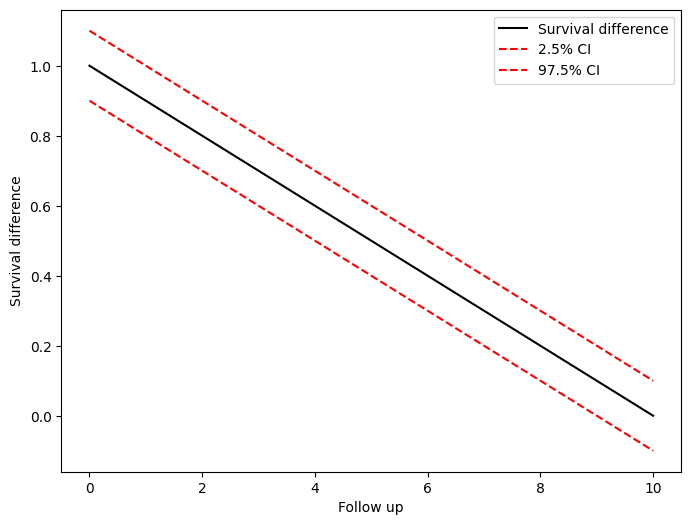

In [261]:
# Call predict on the trial_itt object with newdata and predict_times 0 to 10
preds = predict(
    trial_itt,
    newdata=trial_itt.outcome_data[trial_itt.outcome_data['period'] == 1],
    predict_times=range(0, 11),
    type="survival"
)


# Plot the predicted survival difference and confidence intervals
plt.figure(figsize=(8, 6))
plt.plot(preds["difference"]["followup_time"],
         preds["difference"]["survival_diff"],
         label="Survival difference", color="black", linestyle="-")
plt.plot(preds["difference"]["followup_time"],
         preds["difference"]["2.5%"],
         label="2.5% CI", color="red", linestyle="--")
plt.plot(preds["difference"]["followup_time"],
         preds["difference"]["97.5%"],
         label="97.5% CI", color="red", linestyle="--")
plt.xlabel("Follow up")
plt.ylabel("Survival difference")
plt.legend()
plt.show()
